# Imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

# Initnial parameters

In [3]:
epochs = 10
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

train_data = []
test_data = []

train_labels = []
test_labels = []

pred_data = []
pred_labels = []

# Load image files from the dataset

In [4]:
train_images = [f for f in glob.glob(r'../input/gender-classification-dataset/Training' + "/**/*", recursive=True) if not os.path.isdir(f)]
test_images = [f for f in glob.glob(r'../input/gender-classification-dataset/Validation' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(train_images)
random.shuffle(test_images)

print("Train size: " + str(len(train_images)))
print("Test size: " + str(len(test_images)))
                                   

Train size: 47009
Test size: 11649


# Optimalization

In [5]:
train_length = len(train_images)
test_length = len(test_images)

train_ten_precent = int(train_length * 0.2)
test_ten_precent = int(test_length * 0.2)

train_images_ten_precent = []
test_images_ten_precent = []
pred_images = []

for i in range (train_ten_precent):
    train_images_ten_precent.append(train_images[i])
    
for i in range (test_ten_precent):
    test_images_ten_precent.append(test_images[i])

#delete images used for test data
for i in range (test_ten_precent):
    test_images.pop(i)

#now data for prediction have unique images
for i in range (test_ten_precent):
    pred_images.append(test_images[i])

print("Optimized train size: " + str(len(train_images_ten_precent)))
print("Optimized test size: " + str(len(test_images_ten_precent)))
print("Optimized prediction size: " + str(len(pred_images)))

Optimized train size: 9401
Optimized test size: 2329
Optimized prediction size: 2329


# Converting images to arrays and labelling the categories

In [6]:
for img in train_images_ten_precent:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    train_data.append(image)

    label = img.split(os.path.sep)[-2] # ../input/gender-classification-dataset/Training/female/131422.jpg.jpg
    if label == "female":
        label = 1
    else:
        label = 0
        
    train_labels.append([label]) # [[1], [0], [0], ...]

In [7]:
for img in test_images_ten_precent:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    test_data.append(image)

    label = img.split(os.path.sep)[-2] # ../input/gender-classification-dataset/Validation/female/131422.jpg.jpg
    if label == "female":
        label = 1
    else:
        label = 0
        
    test_labels.append([label]) # [[1], [0], [0], ...]

# Pre-processing

In [8]:
train_data = np.array(train_data, dtype="float") / 255.0
train_labels = np.array(train_labels)

trainX = train_data
trainY = train_labels


In [9]:
test_data = np.array(test_data, dtype="float") / 255.0
test_labels = np.array(test_labels)

testX = test_data
testY = test_labels

In [10]:
trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

# Augmenting datset 

In [11]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# Define model

In [12]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# Build model

In [13]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

2022-06-03 18:54:07.849577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 18:54:07.947803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 18:54:07.948551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 18:54:07.950340: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Compile the model

In [14]:
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model

In [15]:
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

2022-06-03 18:54:20.240849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-03 18:54:22.395279: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


146/146 [==============================] - 29s 147ms/step - loss: 0.5881 - accuracy: 0.7683 - val_loss: 2.4199 - val_accuracy: 0.5058
Epoch 2/10
146/146 [==============================] - 21s 141ms/step - loss: 0.3669 - accuracy: 0.8582 - val_loss: 0.4646 - val_accuracy: 0.8325
Epoch 3/10
146/146 [==============================] - 20s 136ms/step - loss: 0.2774 - accuracy: 0.8962 - val_loss: 0.3590 - val_accuracy: 0.8514
Epoch 4/10
146/146 [==============================] - 20s 139ms/step - loss: 0.2333 - accuracy: 0.9115 - val_loss: 0.2002 - val_accuracy: 0.9249
Epoch 5/10
146/146 [==============================] - 21s 143ms/step - loss: 0.2140 - accuracy: 0.9179 - val_loss: 0.2156 - val_accuracy: 0.9257
Epoch 6/10
146/146 [==============================] - 21s 142ms/step - loss: 0.2000 - accuracy: 0.9267 - val_loss: 0.1481 - val_accuracy: 0.9506
Epoch 7/10
146/146 [==============================] - 20s 134ms/step - loss: 0.1778 - accuracy: 0.9325 - val_loss: 0.2274 - val_accuracy: 0.9

# Plot training/validation loss/accuracy

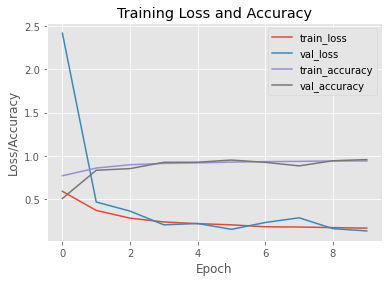

In [17]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Preparing Data for model predictions

In [23]:
for img in pred_images:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    pred_data.append(image)

    label = img.split(os.path.sep)[-2] # ../input/gender-classification-dataset/Validation/female/131422.jpg.jpg
    if label == "female":
        label = 1
    else:
        label = 0
        
    pred_labels.append([label]) # [[1], [0], [0], ...]
    
pred_data = np.array(pred_data, dtype="float") / 255.0
pred_labels = np.array(pred_labels)

# Plot Confusion Matrix

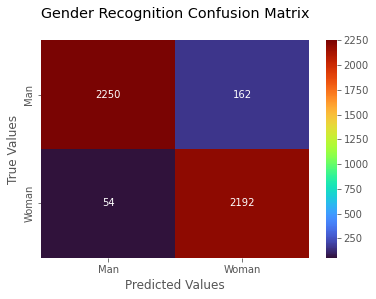

In [25]:
predictions = np.argmax(model.predict(pred_data), axis=-1)

# imports
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

conf_matrix = (confusion_matrix(pred_labels, predictions, labels=[0, 1]))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo', fmt='g')

# labels the title and x, y axis of plot
fx.set_title('Gender Recognition Confusion Matrix\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values');

# labels the boxes
fx.xaxis.set_ticklabels(['Man','Woman'])
fx.yaxis.set_ticklabels(['Man','Woman'])

atlas.show()

# Face recognition

In [26]:
image = cv2.imread('../input/mytest/j2.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

print("[INFO] Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    roi_color = image[y:y + h, x:x + w]
    print("[INFO] Object found. Saving locally.")
    cv2.imwrite(str(w) + 'faces.jpg', roi_color)
    
cv2.imwrite('faces_detected.jpg', image)

[INFO] Found 1 Faces!
[INFO] Object found. Saving locally.


True

# Detected faces

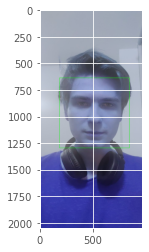

In [27]:
detected_img = cv2.imread('./faces_detected.jpg')
plt.imshow(detected_img)

# Extracted faces

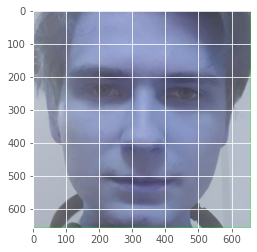

In [28]:
extracted_img = cv2.imread('./658faces.jpg')
plt.imshow(extracted_img)

In [29]:
img_array = []
extracted_img = cv2.resize(extracted_img, (img_dims[0],img_dims[1]))
extracted_img = img_to_array(extracted_img)
img_array.append(extracted_img)
img_array = np.array(img_array, dtype="float") / 255.0

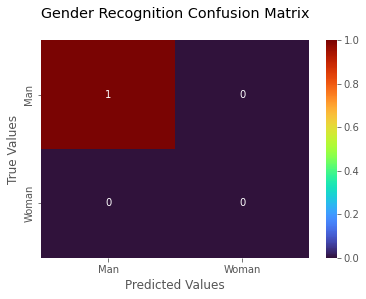

In [30]:
img_prediction = np.argmax(model.predict(img_array), axis=-1)
img_label = []
img_label.append(0)

conf_matrix = (confusion_matrix(img_label, img_prediction, labels=[0, 1]))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo', fmt='g')

# labels the title and x, y axis of plot
fx.set_title('Gender Recognition Confusion Matrix\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('True Values');

# labels the boxes
fx.xaxis.set_ticklabels(['Man','Woman'])
fx.yaxis.set_ticklabels(['Man','Woman'])

atlas.show()